# Random numbers in JAX

In this notebook, we will see how to generate random numbers in JAX. We will see how to generate random numbers from different distributions and how to set the seed for reproducibility. Finally, we will see how one might implement the [Barnsley fern](https://en.wikipedia.org/wiki/Barnsley_fern) fractal using random numbers in JAX.


## Barnsley fern

The Barnsley fern is a fractal named after the British mathematician Michael Barnsley. It is constructed using a set of four affine transformations. The transformations are chosen randomly with probabilities $p_1, p_2, p_3, p_4$. The Barnsley fern is a self-similar fractal, meaning that it is made up of smaller copies of itself. The fern is constructed by starting at the origin and applying one of the four transformations at random. This process is repeated many times to generate the fern.

The four transformations are:
$$
\begin{array}{|c|c|c|l|}
    w & \text{Transformation} & \text{Probability} & \text{Portion generated} \\ \hline
    f_1 & \begin{bmatrix} 0 & 0 \\ 0 & 0.16 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} & 0.01 & \text{Stem} \\
    f_2 & \begin{bmatrix} 0.85 & 0.04 \\ -0.04 & 0.85 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 0 \\ 1.60 \end{bmatrix} & 0.85 & \text{Successively smaller leaflets} \\
    f_3 & \begin{bmatrix} 0.20 & -0.26 \\ 0.23 & 0.22 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 0 \\ 1.60 \end{bmatrix} & 0.07 & \text{Largest left-hand leaflet} \\
    f_4 & \begin{bmatrix} -0.15 & 0.28 \\ 0.26 & 0.24 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 0 \\ 0.44 \end{bmatrix} & 0.07 & \text{Largest right-hand leaflet} \\
\end{array}
$$

In [34]:
import jax.numpy as jnp
from jax import random, jit, vmap, Array, lax
from typing import NamedTuple


class BarnsleyFern(NamedTuple):
    Ws: Array
    bs: Array
    probabilities: Array = jnp.array([0.01, 0.85, 0.07, 0.07])


def setup_transformations() -> BarnsleyFern:
    W1 = jnp.array([[0.0, 0.0], [0.0, 0.16]])
    b1 = jnp.array([0.0, 0.0])

    W2 = jnp.array([[0.85, 0.04], [-0.04, 0.85]])
    b2 = jnp.array([0.0, 1.6])

    W3 = jnp.array([[0.2, -0.26], [0.23, 0.22]])
    b3 = jnp.array([0.0, 1.6])

    W4 = jnp.array([[-0.15, 0.28], [0.26, 0.24]])
    b4 = jnp.array([0.0, 0.44])

    Ws = jnp.stack([W1, W2, W3, W4])
    bs = jnp.array([b1, b2, b3, b4])

    return BarnsleyFern(Ws, bs)


def pick_function(p: Array, cumul_prob: Array) -> int:
    return jnp.argmax(p < cumul_prob)


## Create the barnsley fern fractal
def barnsley_fern(
    rng: random.PRNGKey,
    n_points: int,
    fern: BarnsleyFern = None,
) -> Array:
    if fern is None:
        fern = setup_transformations()

    cumul_prob = jnp.cumsum(fern.probabilities)

    Ws, bs = fern.Ws, fern.bs

    def inner_loop(carry: tuple[random.PRNGKey, Array], x: Array):
        key, x0 = carry
        key, subkey = random.split(key)
        p = random.uniform(subkey)
        i = pick_function(p, cumul_prob)

        W = Ws[i]
        b = bs[i]

        new_x = W @ x0 + b

        return (key, new_x), new_x

    init = (rng, jnp.zeros(2))
    _, points = lax.scan(inner_loop, init, xs=None, length=n_points)

    return points

In [47]:
rng = random.PRNGKey(2000)
n_points = 1000000

points = barnsley_fern(rng, n_points)

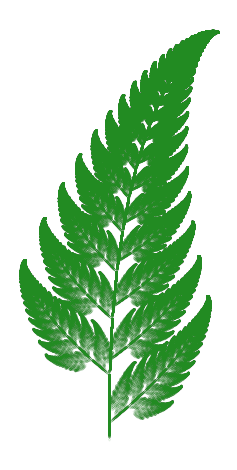

In [78]:
import matplotlib.pyplot as plt

# plt.ion()


def plot(points: Array) -> None:
    plt.scatter(
        points[:, 0], points[:, 1], marker=".", s=0.01, alpha=0.5, color="forestgreen"
    )
    plt.axis("scaled")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("../figures/barnsley_fern.png", dpi=500, transparent=True)
    plt.show()


plot(points)